# Data Cleaning and Preprocessing
## Diabetes Risk & Insulin Management System

This notebook performs comprehensive data cleaning and preprocessing including:
- Handling missing values
- Outlier detection and treatment
- Physiological bounds validation
- Data type conversions
- Duplicate removal


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys

# Add parent directory to path
sys.path.insert(0, str(Path().resolve().parent))

from src.utils.config import (
    DATA_RAW, DATA_CLEAN, OUTLIER_COLS, PHYSIOLOGICAL_BOUNDS,
    TARGET, PATIENT_ID_COL, DATE_COLS
)

warnings.filterwarnings('ignore')
%matplotlib inline

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load Raw Data


In [2]:
# Load raw data
df_raw = pd.read_csv(DATA_RAW)

print(f"Raw data shape: {df_raw.shape}")
print(f"\nColumns: {list(df_raw.columns)}")
print(f"\nFirst few rows:")
df_raw.head()


Raw data shape: (4981, 17)

Columns: ['Patient_ID', 'Timestamp', 'Glucose_Level', 'Heart_Rate', 'Activity_Level', 'Calories_Burned', 'Sleep_Duration', 'Step_Count', 'Insulin_Dose', 'Medication_Intake', 'Diet_Quality_Score', 'Stress_Level', 'BMI', 'HbA1c', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic', 'Predicted_Progression']

First few rows:


,Patient_ID,Timestamp,Glucose_Level,Heart_Rate,Activity_Level,Calories_Burned,Sleep_Duration,Step_Count,Insulin_Dose,Medication_Intake,Diet_Quality_Score,Stress_Level,BMI,HbA1c,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Predicted_Progression
0,P052,2025-06-01 00:00:00,165.7,67.0,68,193.1,4.4,8832,8,1,8,4,26.2,5.5,109,68,1
1,P093,2025-06-01 00:15:00,114.0,70.0,38,205.9,4.3,2255,0,0,5,9,24.5,6.2,152,79,1
2,P015,2025-06-01 00:30:00,125.2,81.0,69,274.5,6.1,1299,4,1,8,9,26.0,5.5,143,99,2
3,P072,2025-06-01 00:45:00,157.1,82.0,99,141.9,4.2,8809,10,1,4,9,22.1,6.8,112,60,0
4,P061,2025-06-01 01:00:00,156.8,62.0,3,245.7,7.7,5521,10,0,10,3,21.4,7.7,152,72,1


## 2. Initial Data Quality Check


In [3]:
# Check data quality
print("=" * 60)
print("INITIAL DATA QUALITY CHECK")
print("=" * 60)

print(f"\nShape: {df_raw.shape}")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Missing values
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print("\nMissing Values:")
    print(missing_df)
else:
    print("\nNo missing values found!")

# Duplicates
duplicates = df_raw.duplicated().sum()
print(f"\nDuplicate rows: {duplicates} ({duplicates/len(df_raw)*100:.2f}%)")

# Data types
print("\nData Types:")
print(df_raw.dtypes)


INITIAL DATA QUALITY CHECK

Shape: (4981, 17)
Memory usage: 1.14 MB

No missing values found!

Duplicate rows: 0 (0.00%)

Data Types:
Patient_ID                   object
Timestamp                    object
Glucose_Level               float64
Heart_Rate                  float64
Activity_Level                int64
Calories_Burned             float64
Sleep_Duration              float64
Step_Count                    int64
Insulin_Dose                  int64
Medication_Intake             int64
Diet_Quality_Score            int64
Stress_Level                  int64
BMI                         float64
HbA1c                       float64
Blood_Pressure_Systolic       int64
Blood_Pressure_Diastolic      int64
Predicted_Progression         int64
dtype: object


## 3. Apply Physiological Bounds (Safety First!)


In [4]:
# Apply physiological bounds
df = df_raw.copy()
initial_count = len(df)

print("=" * 60)
print("APPLYING PHYSIOLOGICAL BOUNDS")
print("=" * 60)

rows_removed = 0
for col, (lower, upper) in PHYSIOLOGICAL_BOUNDS.items():
    if col in df.columns:
        before = len(df)
        mask = df[col].between(lower, upper)
        df = df[mask]
        after = len(df)
        removed = before - after
        rows_removed += removed
        if removed > 0:
            print(f"{col}: Removed {removed} rows (bounds: {lower}-{upper})")

print(f"\nTotal rows removed: {rows_removed}")
print(f"Rows remaining: {len(df)} ({len(df)/initial_count*100:.2f}% of original)")

df = df.reset_index(drop=True)


APPLYING PHYSIOLOGICAL BOUNDS
Glucose_Level: Removed 1 rows (bounds: 40-400)
Activity_Level: Removed 4445 rows (bounds: 0-10)

Total rows removed: 4446
Rows remaining: 535 (10.74% of original)


## 4. Handle Missing Values


In [5]:
# Handle missing values
print("=" * 60)
print("HANDLING MISSING VALUES")
print("=" * 60)

missing_before = df.isnull().sum().sum()
print(f"Missing values before: {missing_before}")

# Strategy: Forward fill for time-series data, median for others
if PATIENT_ID_COL in df.columns:
    # Forward fill within each patient
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        if col != PATIENT_ID_COL and df[col].isnull().sum() > 0:
            df[col] = df.groupby(PATIENT_ID_COL)[col].fillna(method='ffill')
            # Fill remaining with median
            df[col] = df[col].fillna(df[col].median())

missing_after = df.isnull().sum().sum()
print(f"Missing values after: {missing_after}")
print(f"Missing values handled: {missing_before - missing_after}")


HANDLING MISSING VALUES
Missing values before: 0
Missing values after: 0
Missing values handled: 0


## 5. Outlier Detection and Treatment (Winsorization)


OUTLIER TREATMENT (IQR WINSORIZATION)



Outliers capped (IQR method):
  Glucose_Level: 1 values
  Heart_Rate: 1 values
  Calories_Burned: 2 values
  BMI: 6 values
  HbA1c: 1 values


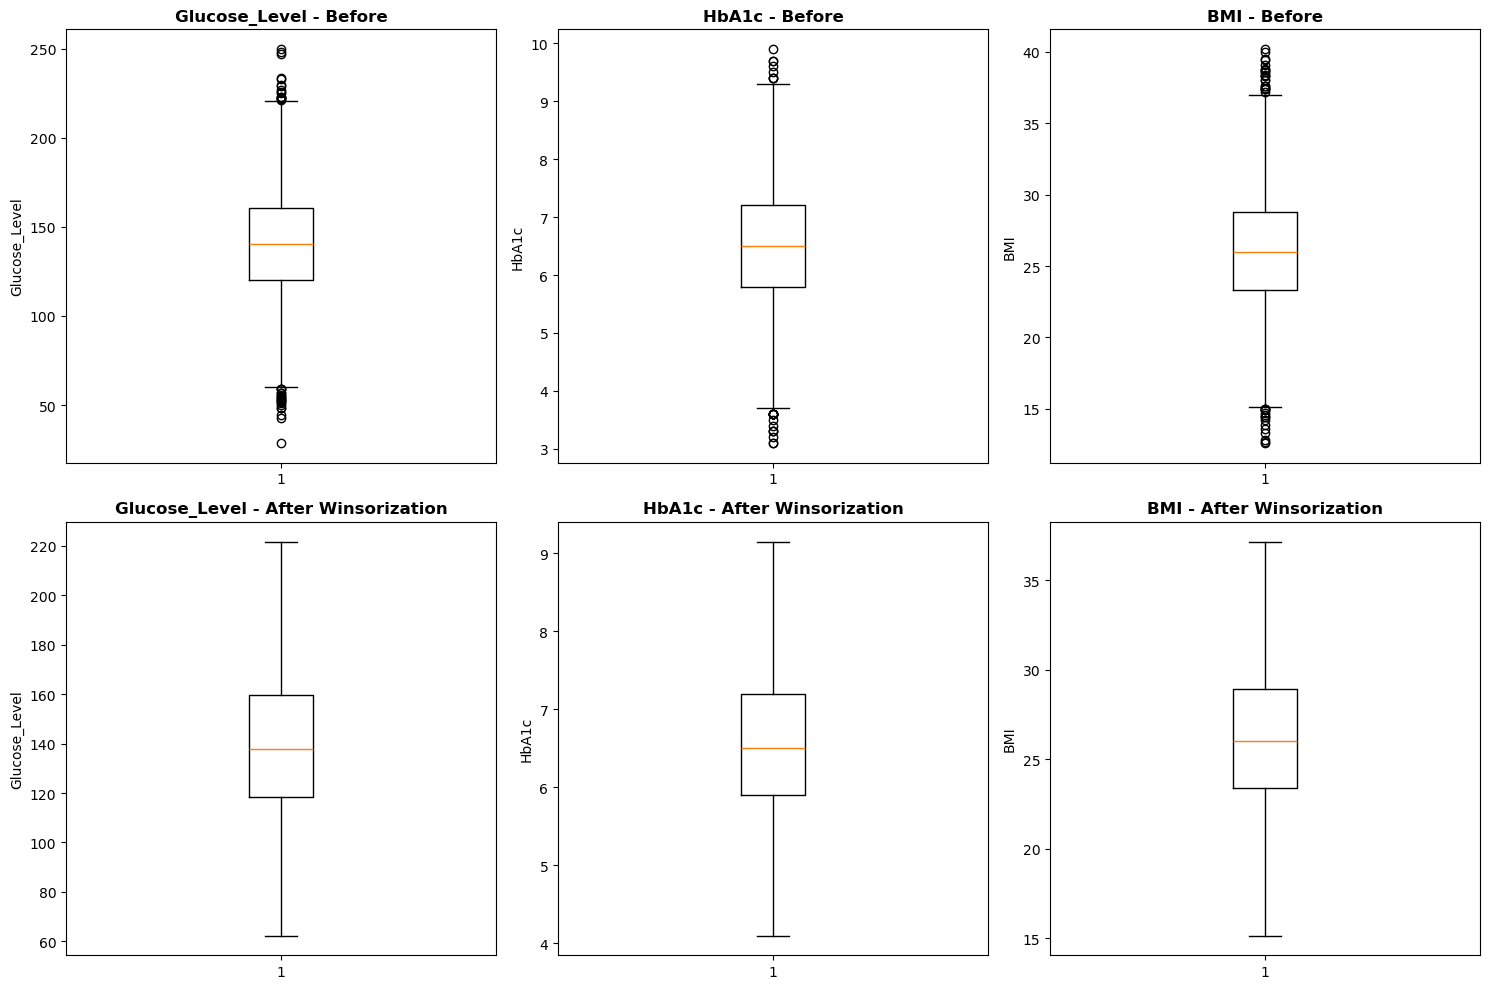

In [6]:
# Outlier treatment using IQR Winsorization
print("=" * 60)
print("OUTLIER TREATMENT (IQR WINSORIZATION)")
print("=" * 60)

def iqr_winsorize(df, cols, factor=1.5, verbose=True):
    df_out = df.copy()
    capped = {}
    
    for col in cols:
        if col not in df_out.columns:
            continue
        
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        
        n_low = (df_out[col] < lower).sum()
        n_high = (df_out[col] > upper).sum()
        capped[col] = n_low + n_high
        
        df_out[col] = df_out[col].clip(lower=lower, upper=upper)
    
    if verbose:
        print("\nOutliers capped (IQR method):")
        for c, n in capped.items():
            if n > 0:
                print(f"  {c}: {n} values")
    
    return df_out, capped

# Apply winsorization
df, capped_counts = iqr_winsorize(df, OUTLIER_COLS, factor=1.5, verbose=True)

# Visualize before/after for key features
key_features = ['Glucose_Level', 'HbA1c', 'BMI', 'Insulin_Dose']
key_features = [f for f in key_features if f in df.columns and f in OUTLIER_COLS]

if len(key_features) > 0:
    fig, axes = plt.subplots(2, len(key_features), figsize=(5*len(key_features), 10))
    if len(key_features) == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, feature in enumerate(key_features):
        # Before
        axes[0, idx].boxplot(df_raw[feature].dropna())
        axes[0, idx].set_title(f'{feature} - Before', fontweight='bold')
        axes[0, idx].set_ylabel(feature)
        
        # After
        axes[1, idx].boxplot(df[feature].dropna())
        axes[1, idx].set_title(f'{feature} - After Winsorization', fontweight='bold')
        axes[1, idx].set_ylabel(feature)
    
    plt.tight_layout()
    plt.show()


## 6. Parse and Enrich Timestamp Features


In [7]:
# Parse timestamp and create time features
print("=" * 60)
print("TIMESTAMP PARSING AND ENRICHMENT")
print("=" * 60)

if DATE_COLS and DATE_COLS[0] in df.columns:
    timestamp_col = DATE_COLS[0]
    
    # Parse timestamp
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    invalid_timestamps = df[timestamp_col].isna().sum()
    
    if invalid_timestamps > 0:
        print(f"Removing {invalid_timestamps} rows with invalid timestamps")
        df = df.dropna(subset=[timestamp_col])
    
    # Create time features
    df['Timestamp_hour'] = df[timestamp_col].dt.hour
    df['Timestamp_dow'] = df[timestamp_col].dt.dayofweek
    df['Timestamp_month'] = df[timestamp_col].dt.month
    df['Timestamp_is_weekend'] = df[timestamp_col].dt.dayofweek.isin([5, 6]).astype(int)
    df['Timestamp_ts'] = df[timestamp_col].astype('int64') // 10**9
    
    # Cyclical encoding for hour
    df['Timestamp_sin_hour'] = np.sin(2 * np.pi * df['Timestamp_hour'] / 24)
    df['Timestamp_cos_hour'] = np.cos(2 * np.pi * df['Timestamp_hour'] / 24)
    
    # Sort chronologically per patient
    if PATIENT_ID_COL in df.columns:
        df = df.sort_values([PATIENT_ID_COL, timestamp_col]).reset_index(drop=True)
        
        # Time delta from previous record
        df['time_delta_hours'] = df.groupby(PATIENT_ID_COL)[timestamp_col].diff().dt.total_seconds() / 3600
        df['time_delta_hours'] = df['time_delta_hours'].fillna(0).clip(lower=0, upper=48)
    
    # Drop original timestamp column
    df = df.drop(columns=[timestamp_col], errors='ignore')
    
    print("Time features created:")
    time_features = [col for col in df.columns if 'Timestamp' in col or 'time_delta' in col]
    print(f"  {len(time_features)} time features: {time_features}")
else:
    print("No timestamp column found")


TIMESTAMP PARSING AND ENRICHMENT
Time features created:
  8 time features: ['Timestamp_hour', 'Timestamp_dow', 'Timestamp_month', 'Timestamp_is_weekend', 'Timestamp_ts', 'Timestamp_sin_hour', 'Timestamp_cos_hour', 'time_delta_hours']


## 7. Remove Duplicates


In [8]:
# Remove duplicates
print("=" * 60)
print("REMOVING DUPLICATES")
print("=" * 60)

before = len(df)
if PATIENT_ID_COL in df.columns and 'Timestamp_ts' in df.columns:
    df = df.drop_duplicates(subset=[PATIENT_ID_COL, 'Timestamp_ts'])
else:
    df = df.drop_duplicates()

after = len(df)
removed = before - after

print(f"Rows before: {before}")
print(f"Rows after: {after}")
print(f"Duplicates removed: {removed}")

df = df.reset_index(drop=True)


REMOVING DUPLICATES
Rows before: 535
Rows after: 535
Duplicates removed: 0


## 8. Final Data Quality Check


In [9]:
# Final quality check
print("=" * 60)
print("FINAL DATA QUALITY CHECK")
print("=" * 60)

print(f"\nFinal shape: {df.shape}")
print(f"Rows removed: {len(df_raw) - len(df)} ({(1 - len(df)/len(df_raw))*100:.2f}%)")

# Check for missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print("\nRemaining missing values:")
    print(missing[missing > 0])
else:
    print("\nNo missing values remaining!")

# Check data types
print("\nData types:")
print(df.dtypes.value_counts())

# Summary statistics
print("\nSummary statistics:")
print(df.describe())


FINAL DATA QUALITY CHECK

Final shape: (535, 24)
Rows removed: 4446 (89.26%)

No missing values remaining!

Data types:
int64      11
float64     9
int32       3
object      1
Name: count, dtype: int64

Summary statistics:


       Glucose_Level  Heart_Rate  Activity_Level  Calories_Burned  \
count     535.000000  535.000000      535.000000       535.000000   
mean      138.248785   74.514953        4.942056       198.405140   
std        29.929294   10.027806        3.222464        49.050563   
min        62.300000   44.500000        0.000000        63.225000   
25%       118.300000   67.000000        2.000000       165.300000   
50%       137.800000   75.000000        5.000000       201.400000   
75%       159.700000   82.000000        8.000000       233.350000   
max       221.800000  100.000000       10.000000       319.200000   

       Sleep_Duration   Step_Count  Insulin_Dose  Medication_Intake  \
count      535.000000   535.000000    535.000000         535.000000   
mean         6.477383  5401.798131      4.919626           0.471028   
std          1.446432  2674.904199      3.384129           0.499627   
min          4.000000  1022.000000      0.000000           0.000000   
25%          5.300000  

## 9. Save Cleaned Data


In [10]:
# Save cleaned data
DATA_CLEAN.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(DATA_CLEAN, index=False)

print("=" * 60)
print("CLEANED DATA SAVED")
print("=" * 60)
print(f"Saved to: {DATA_CLEAN}")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


CLEANED DATA SAVED
Saved to: C:\Users\Dell\Machine_Learning\Insulin_system\Diabetes_Risk_Isulin_Management_System\data\processed\cleaned_no_outliers.csv
Shape: (535, 24)

First few rows:


,Patient_ID,Glucose_Level,Heart_Rate,Activity_Level,Calories_Burned,Sleep_Duration,Step_Count,Insulin_Dose,Medication_Intake,Diet_Quality_Score,...,Blood_Pressure_Diastolic,Predicted_Progression,Timestamp_hour,Timestamp_dow,Timestamp_month,Timestamp_is_weekend,Timestamp_ts,Timestamp_sin_hour,Timestamp_cos_hour,time_delta_hours
0,P001,98.2,62.0,8,165.4,8.7,1266,2,1,3,...,72,0,22,1,6,0,1749593700,-0.500000,0.866025,0.00
1,P001,176.4,62.0,9,230.8,4.5,8614,2,1,10,...,86,0,14,3,6,0,1749738600,-0.500000,-0.866025,40.25
2,P001,168.8,92.0,10,249.1,5.6,5220,8,0,10,...,99,2,0,5,6,1,1749861000,0.000000,1.000000,34.00
3,P001,115.0,82.0,9,152.8,6.1,1275,6,1,2,...,66,0,21,0,6,0,1750108500,-0.707107,0.707107,48.00
4,P001,118.8,67.0,10,204.5,9.0,4087,2,1,8,...,79,0,7,5,7,1,1752305400,0.965926,-0.258819,48.00
